In [1]:
import re
from matplotlib import pyplot as plt
from matplotlib import rcParams
import pandas as pd
import numpy as np
import os
from scipy import signal
plt.show()
rcParams['figure.figsize'] = [10, 6]

In [2]:
def loadData(directory):
    path = f"{directory}/log.interFoam"

    cos = []
    maxcos = []
    ts = []
    pos = []
    vels = []
    with open(path) as file:
        text = file.read()

        centre_lines = re.findall(r'Courant Number mean: ([\d\.e-]+) max: ([\d\.e-]+).*?' +
            r'Time = ([\d\.e-]+)\n+.*?' +
            r'Linear velocity: \(([\d\.e-]+) ([\d\.e-]+) ([\d\.e-]+)\)\n+.*?' +
            r'Centre of rotation: \(([\d\.e-]+) ([\d\.e-]+) ([\d\.e-]+)\)', text, flags=re.DOTALL)

    for line in centre_lines:
        cos.append(float(line[0]))
        maxcos.append(float(line[1]))
        ts.append(float(line[2]))
        vels.append(float(line[5]))
        pos.append(float(line[8]))

    df = pd.DataFrame()
    df["time"] = (np.array(ts) * (10 ** 6)).astype('int64') * 1.0
    df["mean Co"] = np.array(cos)
    df["max Co"] = np.array(maxcos)
    df["heave"] = np.array(pos)
    df["velocity"] = np.array(vels)
    df["t"] = pd.to_timedelta(df["time"], unit='us')
    df.set_index('t', inplace=True)
    df["time"] /= 10 ** 6
    return df

In [3]:
dirs = [f.path for f in os.scandir('Simulation results/') if f.is_dir()]
dirs = [path for path in dirs if re.match('.*/mesh \w', path)]
dirs = [f.path for path in dirs for f in os.scandir(path + '/') if f.is_dir()]
dirs = [path for path in dirs if re.match('.*/.*/Run \d', path)]
dirs.sort(key=lambda x: int(x.split(' ')[-1]))
dirs

['Simulation results/mesh D/Run 1',
 'Simulation results/mesh D/Run 2',
 'Simulation results/mesh D/Run 3',
 'Simulation results/mesh D/Run 4',
 'Simulation results/mesh A/Run 5',
 'Simulation results/mesh B/Run 6',
 'Simulation results/mesh C/Run 7',
 'Simulation results/mesh D/Run 8',
 'Simulation results/mesh E/Run 9',
 'Simulation results/mesh E/Run 10',
 'Simulation results/mesh E/Run 11',
 'Simulation results/mesh E/Run 12',
 'Simulation results/mesh E/Run 13',
 'Simulation results/mesh E/Run 14',
 'Simulation results/mesh E/Run 15',
 'Simulation results/mesh E/Run 16',
 'Simulation results/mesh E/Run 17',
 'Simulation results/mesh E/Run 18',
 'Simulation results/mesh E/Run 19',
 'Simulation results/mesh E/Run 20',
 'Simulation results/mesh E/Run 21',
 'Simulation results/mesh E/Run 22',
 'Simulation results/mesh E/Run 23',
 'Simulation results/mesh E/Run 24',
 'Simulation results/mesh E/Run 25']

In [4]:
dfs = {}

equilibrium = {'A': 0.0065785, 'B': 0.0065992, 'C': 0.0065992, 'D': 0.0065962, 'E': 0.0096642}

for path in dirs:
    label = path.split('/')[-1]
    mesh = path.split('/')[-2][-1]
    df = loadData(path)
    df['heave'] -= equilibrium[mesh]
    print(label, df.size)
    dfs[label] = df

Run 1 1715
Run 2 6960
Run 3 6605
Run 4 6605
Run 5 4235
Run 6 14685
Run 7 25525
Run 8 8215
Run 9 26290
Run 10 64975
Run 11 37475
Run 12 30880
Run 13 60545
Run 14 33640
Run 15 29735
Run 16 84635
Run 17 46050
Run 18 45185
Run 19 109665
Run 20 55865
Run 21 43740
Run 22 42725
Run 23 44800
Run 24 46050
Run 25 46050


In [5]:
data51 = pd.read_csv("./experimental/MeasurementRawData_51.lvm", skiprows=24, sep="\s+", header=None)
data52 = pd.read_csv("./experimental/MeasurementRawData_52.lvm", skiprows=24, sep="\s+", header=None)
data53 = pd.read_csv("./experimental/MeasurementRawData_53.lvm", skiprows=24, sep="\s+", header=None)
N = 100
for data in (data51, data52, data53):
    data[3] = np.convolve(data[2], np.ones(N) / N, mode='same')
    data[4] = np.diff(data[3], prepend=[0])
    data[5] = np.convolve(data[4], np.ones(N) / 2, mode='same')
    data.drop(data.tail(N).index, inplace=True)
data51 = data51[(data51[0]>116.89)]
data52 = data52[(data52[0]>15.5)]
data53 = data53[(data53[0]>43.4)]
datalabels = [(data51, "case 51"), (data52, "case 52"), (data53, "case 53")]

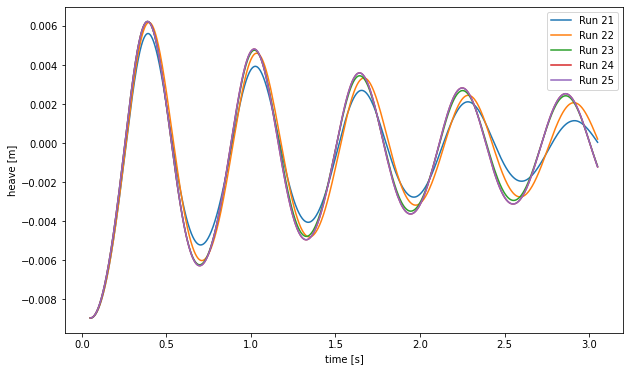

In [6]:
# for (data, label) in datalabels:
#     times = data[0] - data[0].min()
#     ys = data[2]
#     ys = (ys[times <= 3] - data[2].mean()) / 1000
#     times = times[times <= 3]
#     plt.plot(times, ys, label = label, alpha=0.3)
for label in ['Run 21', 'Run 22', 'Run 23', 'Run 24', 'Run 25']: #in dfs:
    df = dfs[label]
    plt.plot(df['time'] + 0.05, df['heave'] + 0.0007, '-', label = label)
plt.xlabel("time [s]")
plt.ylabel("heave [m]")
plt.legend();

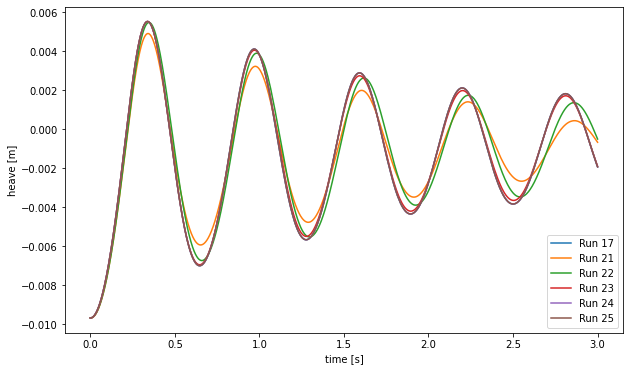

In [7]:
for label in ['Run 17', 'Run 21', 'Run 22', 'Run 23', 'Run 24', 'Run 25']:
    df = dfs[label]
    plt.plot(df['time'], df['heave'], label = label)
plt.xlabel("time [s]")
plt.ylabel("heave [m]")
plt.legend()
# plt.ylim((-0.007,0.005))

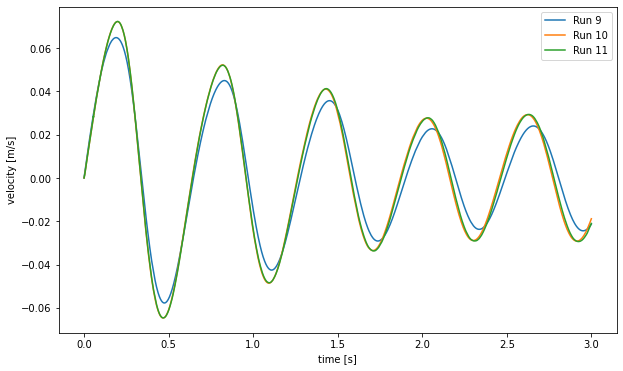

In [8]:
for label in ['Run 9', 'Run 10', 'Run 11']:
    df = dfs[label]
    plt.plot(df['time'], df['velocity'], label = label)
    plt.xlabel("time [s]")
    plt.ylabel("velocity [m/s]")
    plt.legend()

1.99724500796
2.46506714248
2.68290370398
2.88668655524
2.88668655524


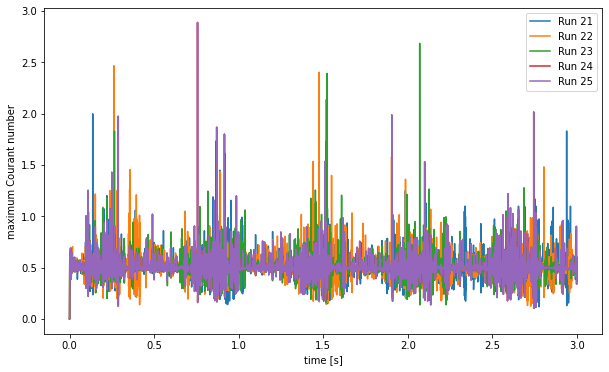

In [9]:
for label in ['Run 21', 'Run 22', 'Run 23', 'Run 24', 'Run 25']:
    df = dfs[label]
    plt.plot(df['time'], df['max Co'], label = label)
    print(df['max Co'].max())
plt.xlabel("time [s]")
plt.ylabel("maximum Courant number")
plt.legend();

0.00348448800625
0.00348030894624
0.00330639519586
0.00347917396069
0.00347917396069


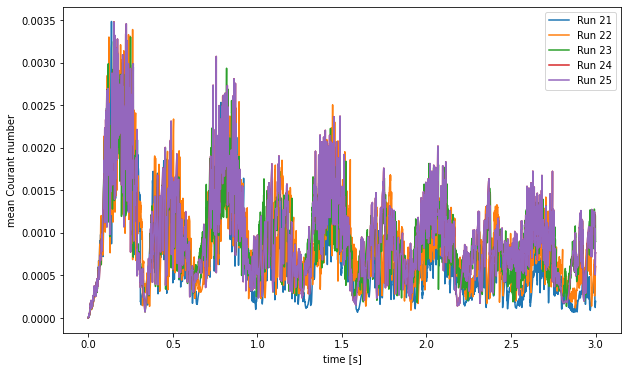

In [10]:
for label in ['Run 21', 'Run 22', 'Run 23', 'Run 24', 'Run 25']:
    df = dfs[label]
    plt.plot(df['time'], df['mean Co'], label = label)
    print(df['mean Co'].max())
plt.xlabel("time [s]")
plt.ylabel("mean Courant number")
plt.legend();

Run 21 0.0003429610152052132
Run 22 0.00035110955056179776
Run 23 0.00033484540685344347
Run 24 0.0003257552394396786
Run 25 0.0003257552394396786


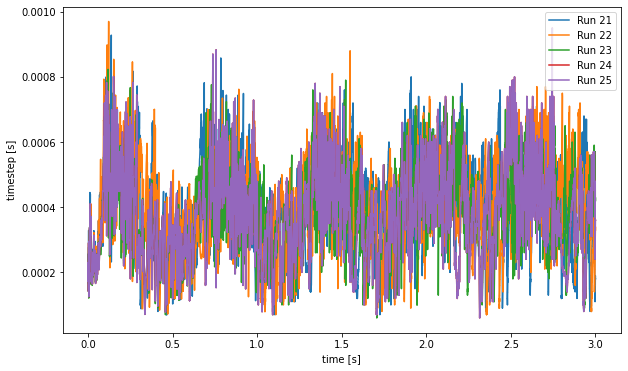

In [11]:
for label in ['Run 21', 'Run 22', 'Run 23', 'Run 24', 'Run 25']:
    df = dfs[label]
    plt.plot(df['time'].values[1:], np.diff(df['time']), label = label)
    print(label, np.diff(df['time']).mean())
plt.xlabel("time [s]")
plt.ylabel("timestep [s]")
plt.legend()

In [12]:
dfrs = {}
for label in dfs:
    df = dfs[label]
    dfr = df.resample('1us').interpolate('cubic').resample('1us').asfreq()
    dfrs[label] = dfr

ValueError: cannot reindex from a duplicate axis

Run 17 1.6667327804002894
Run 21 1.6667327804002894
Run 22 1.6667327804002894
Run 23 1.6667327804002894
Run 24 1.6667327804002894
Run 25 1.6667327804002894


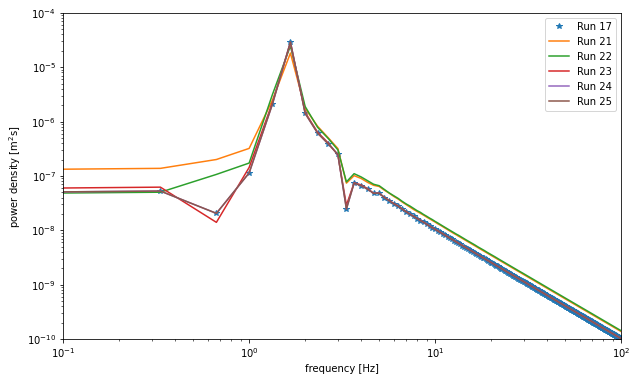

In [ ]:
# for (data, label) in datalabels:
#     times = data[0] - data[0].min()
#     ys = data[2]
#     ys = (ys[times <= 3] - data[2].mean()) / 1000
#     f, s = signal.periodogram(ys, fs=2000)
#     plt.plot(f, s, label=label, alpha=0.3)
for label in ['Run 17', 'Run 21', 'Run 22', 'Run 23', 'Run 24', 'Run 25']:
    dfr = dfrs[label]
    f, s = signal.periodogram(dfr["heave"], fs = 1000000)
    print(label, f[np.argmax(s)])
    plt.plot(f, s, '-' if label != 'Run 17' else '*', label=label)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim((10 ** -10, 10 ** -4))
plt.xlim((0.1, 100))
plt.xlabel("frequency [Hz]")
plt.ylabel(r"power density [$\mathrm{m}^2\mathrm{s}$]");

Run 21 \SI{9.4557e-08}{}
Run 22 \SI{8.0029e-08}{}
Run 23 \SI{1.1572e-08}{}
Run 24 \SI{0.0}{}
Run 25 \SI{0.0}{}


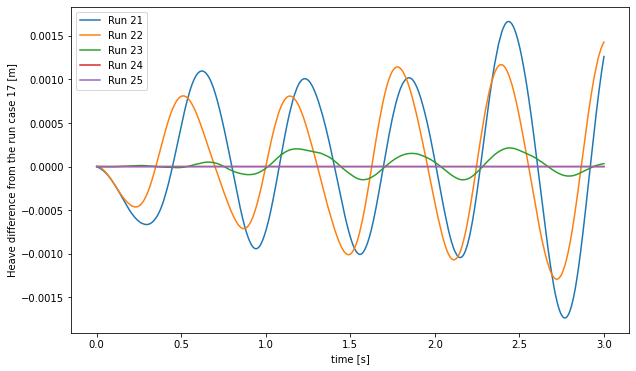

In [ ]:
base = (dfrs["Run 17"])['heave']

for label in ['Run 21', 'Run 22', 'Run 23', 'Run 24', 'Run 25']:
    dfr = dfrs[label]
    plt.plot(dfr['time'], dfr['heave'] - base, label=label)
    print(label, f"\SI{{{np.sum((dfr['heave'] - base) ** 2.0) ** 0.5 / dfr.size:.5}}}{{}}")
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Heave difference from the run case 17 [m]');